# Quantum Support Vector Machines
**Author: Maximilian Forstenhäusler** <br><br><br>
As part of the Seminar: Advanced Topics in Quantum Computing at [TUM](https://www.tum.de/), this notebook experiments with the implementation of Quantum Support Vector Machines. The project entails two notebooks.
- In this notebook, I benchmark my custom implementation of the quantum kernel estimate with the implementation by [`qiskit`](https://www.qiskit.org/), as well as look at the impact of the data maps and the feature maps on the classification performance.
- For more insight on the classical SVM implementation, please see the other notebook -> [Support Vector Machines](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/Support%20Vector%20Machines%20.ipynb)

The source code:
- [nonlinear classifier](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/quantum_svm/svm/linear_classifier.py)
- [quantum feature map](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/quantum_svm/quantum/feature_maps.py)
- [quantum kernel estimate](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/quantum_svm/quantum/kernels.py)

For the full code --> [github/mforstenhaeusler/QSVM](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines)
<br>
## Content
1. [Quantum Kernel](#Quantum-Kernel)<br>
    1.1 [Custom Implementation with Qiskit Circuit](#Custom-Implementation-with-Qiskit-Circuit)<br>
    1.2 [Qiskit Implementation](#Qiskit-Implementation) 
2. [Quantum Support Vector Machine](#Quantum-Support-Vector-Machine)<br>
    2.1 [Compare custom QSVC with qiskit QSVC](#Compare-custom-QSVC-with-qiskit-QSVC)<br>
    2.2 [Adhoc Dataset](#Adhoc-Dataset)<br>
    2.2.1 [Radial Basis Function](#Radial-Basis-Function)<br>
    2.2.2 [Compare Quantum Kernel with RBF Kernel on Adhoc Data](#Compare-Quantum-Kernel-to-RBF-Kernel-on-Adhoc-Data)<br>
    2.2.3 [Compare different Feature Maps](#Compare-different-Feature-Maps)<br>
    2.2.3.1 [ZZ-Feature Map](#ZZFetaureMap)<br>
    2.2.3.2 [Z-Feature Map](#ZFetaureMap)<br>
    2.2.3.3 [Comparison](#Comparison)
3. [Quantum Kernel Comparisons](#Quantum-Kernel-Comparisons)<br>
    3.1 [Plots](#Plots)<br>
    3.2 [Model Performance](#Model-Performance)
4. [References](#References)

In [1]:
from quantum_svm.quantum.feature_maps import ZZFeatureMap as ZZFeatureMap_custom
from quantum_svm.quantum.feature_maps import ZFeatureMap as ZFeatureMap_custom
from quantum_svm.quantum.kernels import QuantumKernel as QuantumKernel_custom
from quantum_svm.quantum.kernel_loader import quantum_kernel_loader
from quantum_svm.quantum.data_maps import DataMap, DataMap_Exp, DataMap_Sin, DataMap_Cos
from quantum_svm.svm.nonlinear_classifier import kernelSVC
from quantum_svm.utils.plot import plot_kernel_SVC, plot_confusion_matrix
from quantum_svm.utils.utils import compare_models, compare_model_performance, accuracy
from quantum_svm.data.data_generators import (
    create_XOR_data, 
    create_moons_data, 
    create_circles_data, 
    adhoc_dataset
)
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd

from qiskit import BasicAer, Aer
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC


from sklearn.svm import SVC

%load_ext autoreload

%autoreload 2

## Quantum Kernel 
### Validation of Custom Implementation

In [2]:
# Initialize Random Data
X = np.random.rand(80,2)

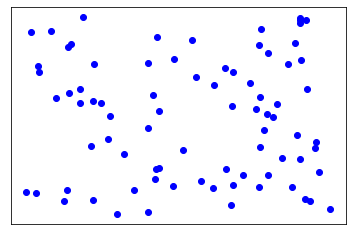

In [3]:
plt.scatter(X[:,0], X[:,1], c='b')
plt.xticks([])
plt.yticks([]);

#### Theory
In order to use a quantum kernel, one needs to transform the classical data to a quantum state.
#### Quantum Feature Maps 
- Maps a classical state vector x to a quantum state vector (Hilbert Space)
- This is done by,
\begin{equation}
    \mathbf{U}_{\Phi}(x) = \prod_d U_{\Phi}(x)\mathcal{H}^{\otimes n}
\end{equation}

**ZZ Feature Map**
\begin{equation}
    \mathbf{U}_{\Phi}(x) = ( \exp(i \sum_{jk} \phi_{j,k}(x) Z_j \otimes Z_k) \exp(i \sum_{j} \phi_{j}(x) Z_j)  \mathcal{H}^{\otimes n})^d
\end{equation}
The feature map is realized by a quantum circuit.  
#### Quantum Kernel
\begin{equation}
    k(x_i, x_j) = \Phi^{\dagger}(x_i) \Phi(x_j)
\end{equation}

For finite data:
\begin{equation}
     K_{ij} = |<\Phi^{\dagger}(x_i)|\Phi(x_j)>|^2 
\end{equation}<br>
\begin{equation}
    |\Phi(x_j)> = U_{\theta}(x_j)|0^{\otimes n}>
\end{equation}

To calculate each element --> calculate the transition amplitude 
\begin{equation}
    |<\Phi^{\dagger}(x_i)|\Phi(x_j)>|^2 = |<0^{\otimes n}|U_{\theta}^{\dagger}(x_i)|U_{\theta}(x_j)|0^{\otimes n}>|^2
\end{equation}
<br>
** **For more information:** [Slides](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/Slides/Quantum_Support_Vector_Machines_final.pdf)

[Return to Content](#Content)

### Custom Implementation with Qiskit Circuit

In [4]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 1,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': None,
}

In [5]:
data_map = DataMap()

zz_map_custom = ZZFeatureMap_custom(
    quantum_params['feature_dimension'], 
    quantum_params['reps'], 
    data_map, 
    insert_barriers=True
)

zz_map_custom

ZZFeatureMap(feature_dimensions=2, reps=1)

In [6]:
backend = Aer.get_backend('qasm_simulator')

zz_kernel = QuantumKernel_custom(feature_map=zz_map_custom, quantum_backend=backend, sim_params=quantum_params)

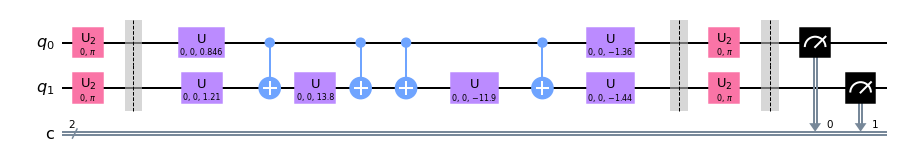

In [7]:
circuit = zz_kernel.construct_circuit(X[0], X[1])
circuit.decompose().decompose().draw('mpl')

In [8]:
QK_custom = zz_kernel.evaluate(X)

### Qiskit Implementation 

/Users/Maxi/.virtualenvs/svm_venv/lib/python3.7/site-packages/sympy/core/expr.py:3951: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  deprecated_since_version="1.9").warn()


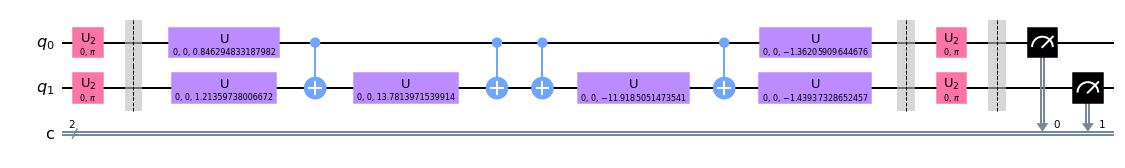

In [9]:
zz_map = ZZFeatureMap(feature_dimension=2, reps=1, entanglement='linear', insert_barriers=True)

zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('qasm_simulator'))

zz_circuit = zz_kernel.construct_circuit(X[0], X[1])
zz_circuit.decompose().decompose().decompose().draw(output='mpl')

In [10]:
QK_qiskit = zz_kernel.evaluate(X)

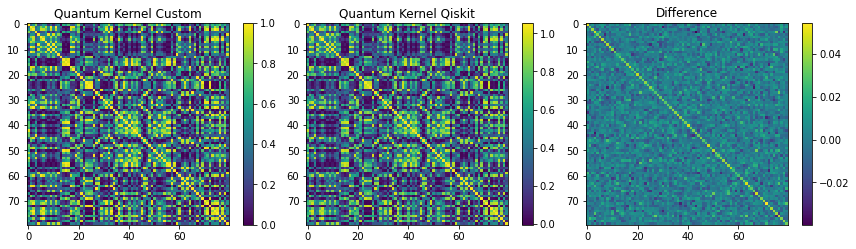

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
im = ax[0].imshow(np.asmatrix(QK_custom),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

ax[0].set_title("Quantum Kernel Custom")
im = ax[1].imshow(np.asmatrix(QK_qiskit),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[1].set_title("Quantum Kernel Qiskit")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = ax[2].imshow(QK_qiskit - QK_custom, interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[2].set_title("Difference")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

fig.tight_layout()
plt.show()

[Return to Content](#Content)

## Quantum Support Vector Machine

In [12]:
alpha_tol = 1e-04
colors = ['red', 'blue']
cmap_custom = pltcolors.ListedColormap(colors)
cmap = plt.cm.RdBu_r


seed = 12

In [13]:
# Params

center = 1
params_xor = {
    'N': 100, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}

params_adhoc = {
    'train_size': 40,
    'test_size': 10,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

In [14]:
datasets = [
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

### Compare custom QSVC with qiskit QSVC

In [15]:
# Load Data
X_xor_train, X_xor_test, y_xor_train, y_xor_test = datasets[0]

In [16]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}

data_map = DataMap()

# set up quntum kernel 
quantum_SVC = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    feature_map=ZZFeatureMap_custom,
    data_map=data_map,
    qiskit=False
)

SVC(kernel='quantum', feature_map='<class 'quantum_svm.quantum.feature_maps.ZZFeatureMap'>', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0]) if S={i,j}')


In [17]:
# train 
quantum_SVC.fit(X_xor_train, y_xor_train)

Computing Quantum Kernel ...
Quantum Kernel computed!
Found 10 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:19<00:00,  1.00batch/s]


Accuracy on training set: 100.0 %


In [18]:
# Predict
y_xor_pred_quantum = quantum_SVC.predict(X_xor_test)

100%|████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/batch]


In [19]:
# adopted from IBM Quantum Lab - qiskit tutorials/wiskit-machine-learning/03_quantum_kernels
# https://lab.quantum-computing.ibm.com/user/6093c4e5b83b3765117f006a/lab/tree/qiskit-tutorials/qiskit-machine-learning/03_quantum_kernel.ipynb
algorithm_globals.random_seed = seed

adhoc_dimension = 2
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, 
                                 reps=2, entanglement='linear')

adhoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)

adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

In [20]:
# Initialize
qsvc = QSVC(quantum_kernel=adhoc_kernel)
# Fit
qsvc.fit(X_xor_train, y_xor_train)
# Score
qsvc_score = qsvc.score(X_xor_test, y_xor_test)
# Predict
qsvc_pred = qsvc.predict(X_xor_test)

# adopted from IBM Quantum Lab - qiskit tutorials/wiskit-machine-learning/03_quantum_kernels

In [21]:
type(qsvc)

qiskit_machine_learning.algorithms.classifiers.qsvc.QSVC

100%|██████████████████████████████████████| 400/400 [06:39<00:00,  1.00batch/s]


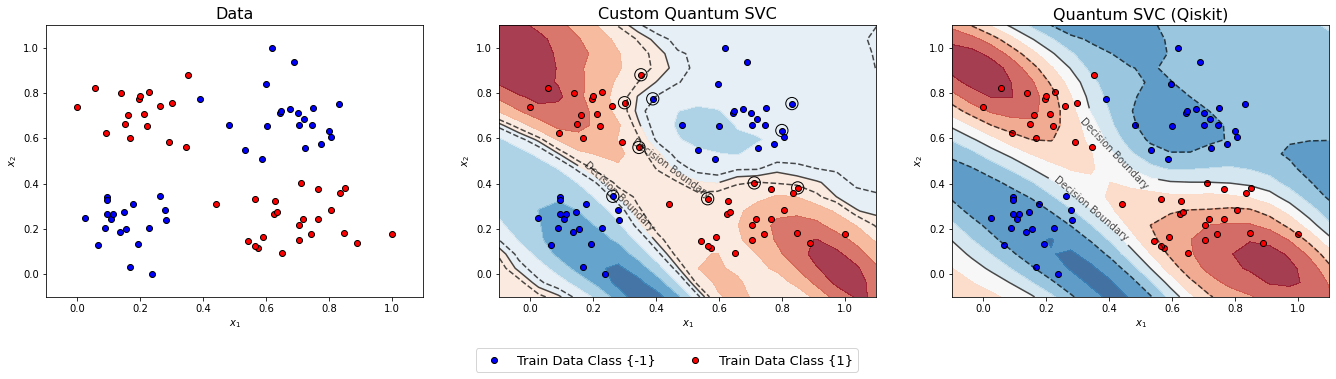

In [22]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [quantum_SVC, qsvc], 
    cmap, 
    titles=["Data", "Custom Quantum SVC", "Quantum SVC (Qiskit)"], 
    kernel='quantum')


Accuracy on test set: 95.0 %
Baseline Accuracy: 95.0 %


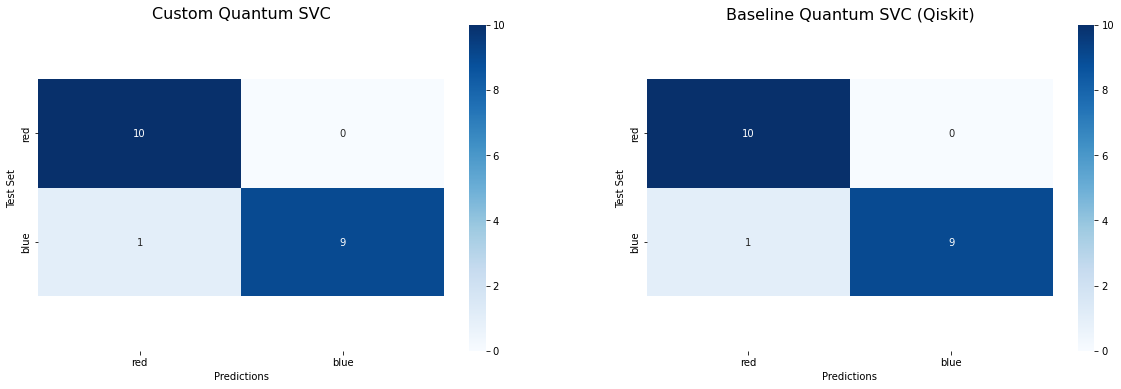

In [23]:
# accuracy
accuracy(y_xor_test, y_xor_pred_quantum, True, mode='test')
print(f'Baseline Accuracy: {qsvc_score*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_xor_pred_quantum,
    qsvc_pred,
    colors, 
    titles=["Custom Quantum SVC", "Baseline Quantum SVC (Qiskit)"]
)

[Return to Content](#Content)

### Adhoc Dataset

https://arxiv.org/pdf/1804.11326.pdf

In [24]:
# Load Data
X_adhoc_train, y_adhoc_train, X_adhoc_test, y_adhoc_test, adhoc_total = datasets[-1]

### Radial Basis Function

In [25]:
# Initialize Model
rbf_SVC_adhoc = kernelSVC(kernel='rbf', C=10)

# Fit Model
rbf_SVC_adhoc.fit(X_adhoc_train, y_adhoc_train)

SVC(kernel='rbf', C=10.0, gamma=0.5)
Found 47 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 2579.90batch/s]


Accuracy on training set: 90.0 %


In [26]:
# Predict
y_adhoc_pred_rbf = rbf_SVC_adhoc.predict(X_adhoc_test)

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 2493.79batch/s]


In [27]:
# Baseline 
baseline_rbf_kernel_SVC_adhoc = SVC(kernel='rbf', C=10, gamma=0.5)

# Fit
baseline_rbf_kernel_SVC_adhoc.fit(X_adhoc_train, y_adhoc_train)

SVC(C=10, gamma=0.5)

In [28]:
# Predict
y_adhoc_pred_baseline_rbf = baseline_rbf_kernel_SVC_adhoc.predict(X_adhoc_test)

# Accuracy
baseline_acc_rbf_adhoc = baseline_rbf_kernel_SVC_adhoc.score(X_adhoc_test, y_adhoc_test)

100%|██████████████████████████████████| 2500/2500 [00:00<00:00, 3680.76batch/s]


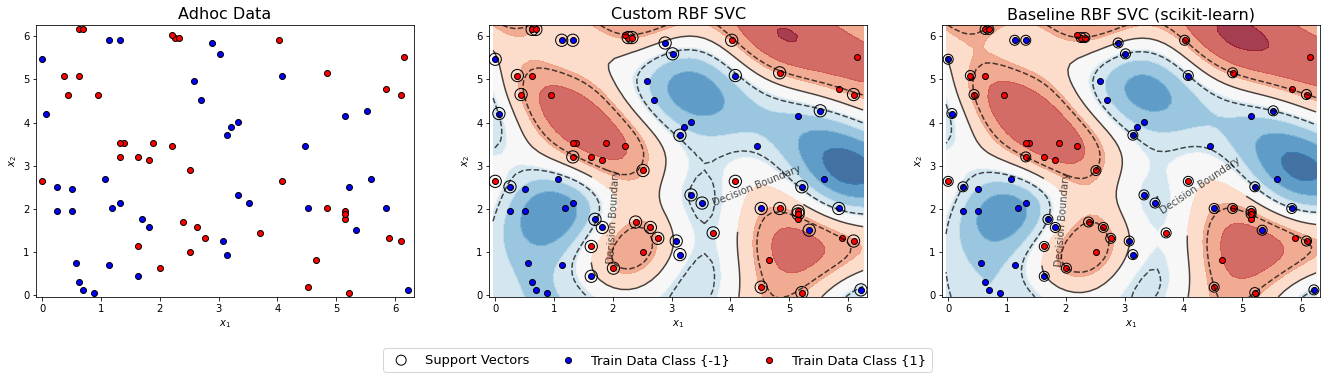

In [29]:
plot_kernel_SVC(
    X_adhoc_train, 
    y_adhoc_train, 
    [rbf_SVC_adhoc, baseline_rbf_kernel_SVC_adhoc], 
    cmap, 
    titles=["Adhoc Data", "Custom RBF SVC", "Baseline RBF SVC (scikit-learn)"], 
    kernel='rbf'
)

Accuracy on test set: 60.0 %
Baseline Accuracy: 60.0 %


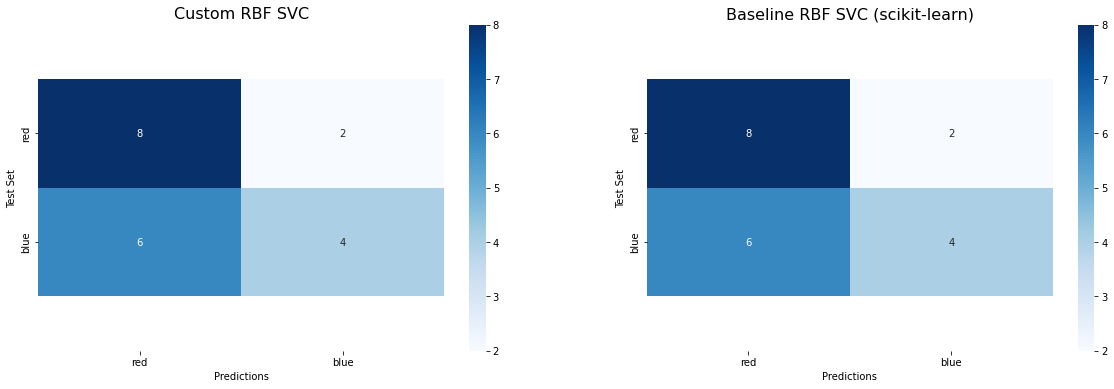

In [30]:
# accuracy
accuracy(y_adhoc_test, y_adhoc_pred_rbf, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_rbf_adhoc*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_adhoc_test, 
    y_adhoc_pred_rbf,
    y_adhoc_pred_baseline_rbf,
    colors, 
    titles=["Custom RBF SVC", "Baseline RBF SVC (scikit-learn)"]
)

[Return to Content](#Content)

### Compare Quantum Kernel to RBF Kernel on Adhoc Data

In [31]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}

data_map = DataMap()

# set up quntum kernel 
quantum_SVC = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    #feature_map=ZZFeatureMap_custom,
    #data_map=data_map,
    qiskit=False
)

SVC(kernel='quantum', feature_map='ZZFeatureMap', data_map='default DataMap')


In [32]:
# train 
quantum_SVC.fit(X_adhoc_train, y_adhoc_train)

Computing Quantum Kernel ...
Quantum Kernel computed!
Found 13 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:45<00:00,  1.32s/batch]


Accuracy on training set: 100.0 %


In [33]:
# predict
y_adhoc_pred_quantum = quantum_SVC.predict(X_adhoc_test)

100%|████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/batch]


100%|████████████████████████████████████| 400/400 [00:00<00:00, 2555.45batch/s]


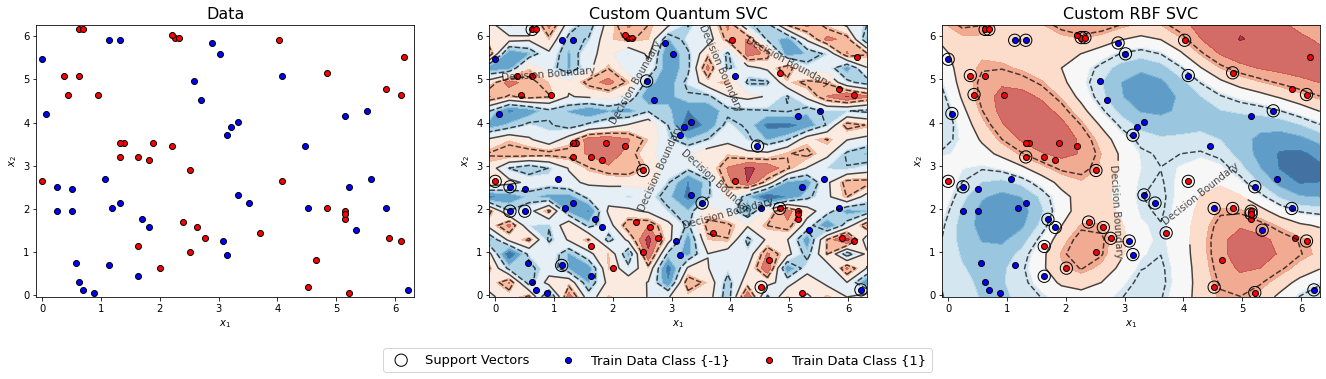

In [34]:
plot_kernel_SVC(
    X_adhoc_train, 
    y_adhoc_train, 
    [quantum_SVC, rbf_SVC_adhoc], 
    cmap, 
    titles=["Data", "Custom Quantum SVC", "Custom RBF SVC"], 
    kernel='quantum')

Accuracy on test set: 100.0 %
Accuracy on test set: 60.0 %


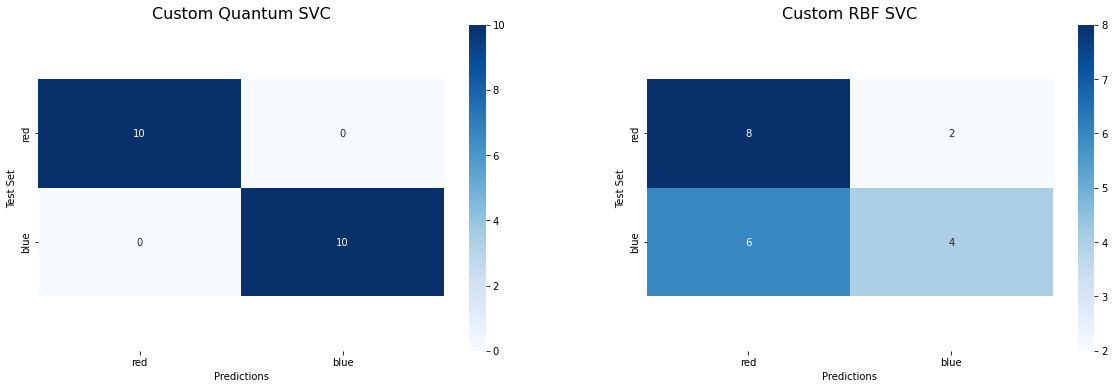

In [35]:
# accuracy
accuracy(y_adhoc_test, y_adhoc_pred_quantum, True, mode='test')
accuracy(y_adhoc_test, y_adhoc_pred_rbf, True, mode='test')

# confusion Matrix plot
plot_confusion_matrix(
    y_adhoc_test, 
    y_adhoc_pred_quantum,
    y_adhoc_pred_rbf,
    colors, 
    titles=["Custom Quantum SVC", "Custom RBF SVC"]
)

In [46]:
pd.DataFrame.from_dict({'Adhoc Data': {"Custom Quantum SVC": y_adhoc_pred_quantum, 
                                       "Custom RBF SVC": y_adhoc_pred_rbf}}).transpose()

,Custom Quantum SVC,Custom RBF SVC
Adhoc Data,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0,..."


[Return to Content](#Content)

### Compare different Feature Maps 

#### ZZFeatureMap

In [37]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 1,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': None,
}

data_map = DataMap()

zz_map_custom = ZZFeatureMap_custom(
    quantum_params['feature_dimension'], 
    quantum_params['reps'], 
    data_map, 
    insert_barriers=True
)

zz_map_custom

ZZFeatureMap(feature_dimensions=2, reps=1)

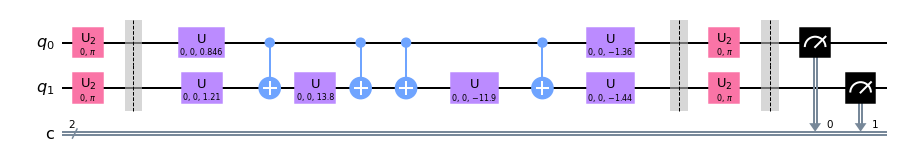

In [38]:
backend = Aer.get_backend('qasm_simulator')

zz_kernel = QuantumKernel_custom(feature_map=zz_map_custom, quantum_backend=backend, sim_params=quantum_params)

circuit = zz_kernel.construct_circuit(X[0], X[1])
circuit.decompose().decompose().draw('mpl')

#### ZFeatureMap

In [39]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 1,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': None,
}

data_map = DataMap()

z_map_custom = ZFeatureMap_custom(
    quantum_params['feature_dimension'], 
    quantum_params['reps'], 
    data_map, 
    insert_barriers=True
)

z_map_custom


ZFeatureMap(feature_dimensions=2, reps=1)

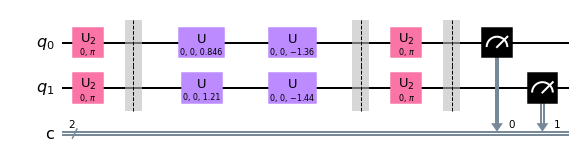

In [40]:
backend = Aer.get_backend('qasm_simulator')

z_kernel = QuantumKernel_custom(feature_map=z_map_custom, quantum_backend=backend, sim_params=quantum_params)

circuit = z_kernel.construct_circuit(X[0], X[1])
circuit.decompose().decompose().draw('mpl')

#### Comparison

In [41]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}

data_map = DataMap()

# set up quntum kernel 
quantum_SVC_z = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    feature_map=ZFeatureMap_custom,
    data_map=data_map,
    qiskit=False
)

quantum_SVC_zz = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    feature_map=ZZFeatureMap_custom,
    data_map=data_map,
    qiskit=False
)

SVC(kernel='quantum', feature_map='<class 'quantum_svm.quantum.feature_maps.ZFeatureMap'>', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0]) if S={i,j}')
SVC(kernel='quantum', feature_map='<class 'quantum_svm.quantum.feature_maps.ZZFeatureMap'>', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0]) if S={i,j}')


In [42]:
# train 
quantum_SVC_z.fit(X_adhoc_train, y_adhoc_train)
quantum_SVC_zz.fit(X_adhoc_train, y_adhoc_train)

Computing Quantum Kernel ...
Quantum Kernel computed!
Found 80 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [07:20<00:00,  5.50s/batch]


Accuracy on training set: 68.75 %
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 13 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:45<00:00,  1.32s/batch]


Accuracy on training set: 100.0 %


In [43]:
# predict
y_adhoc_pred_quantum_z = quantum_SVC_z.predict(X_adhoc_test)
y_adhoc_pred_quantum_zz = quantum_SVC_zz.predict(X_adhoc_test)

100%|████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/batch]


100%|██████████████████████████████████████| 400/400 [09:17<00:00,  1.39s/batch]


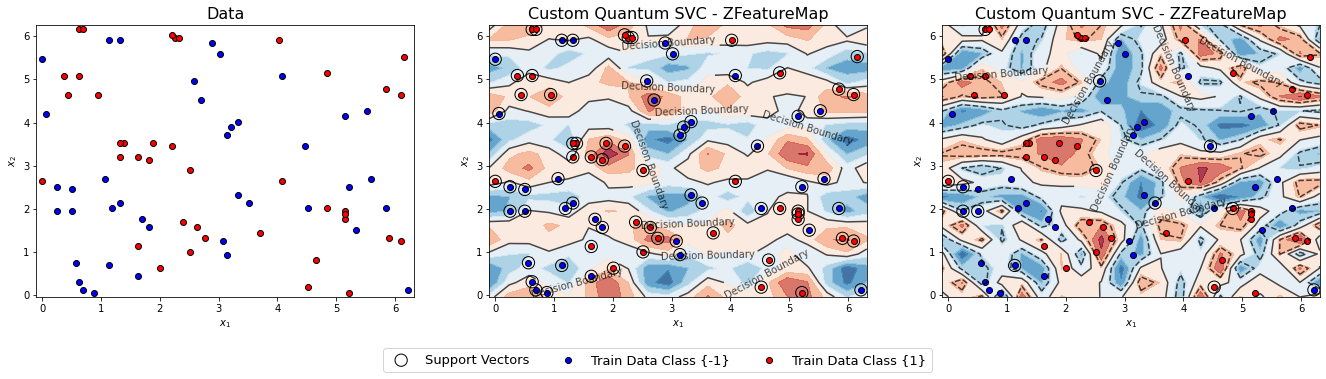

In [44]:
plot_kernel_SVC(
    X_adhoc_train, 
    y_adhoc_train, 
    [quantum_SVC_z, quantum_SVC_zz], 
    cmap, 
    titles=["Data", "Custom Quantum SVC - ZFeatureMap", "Custom Quantum SVC - ZZFeatureMap"], 
    kernel='quantum')

Accuracy on test set: 90.0 %
Accuracy on test set: 100.0 %


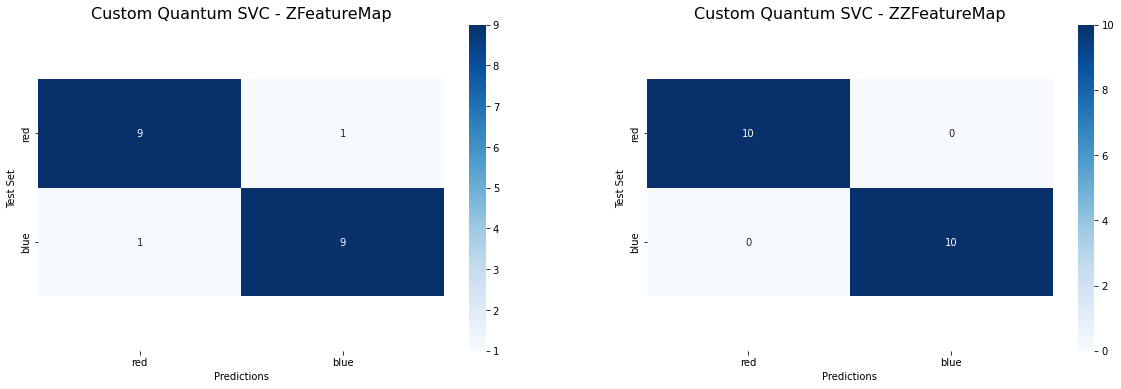

In [45]:
# accuracy
accuracy(y_adhoc_test, y_adhoc_pred_quantum_z, True, mode='test')
accuracy(y_adhoc_test, y_adhoc_pred_quantum_zz, True, mode='test')

# confusion Matrix plot
plot_confusion_matrix(
    y_adhoc_test, 
    y_adhoc_pred_quantum_z,
    y_adhoc_pred_quantum_zz,
    colors, 
    titles=["Custom Quantum SVC - ZFeatureMap", "Custom Quantum SVC - ZZFeatureMap"]
)

[Return to Content](#Content)

## Quantum Kernel Comparisons
### Datasets

In [171]:
# Params

center = 1
params_xor = {
    'N': 10, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}


params_circles = {
    'N': 10, # number of samples
    'factor': 0.4, 
    'noise': 0.1,
    'seed': seed,
}

params_moons = {
    'N': 10, # number of samples
    'noise': 0.15,
    'seed': seed,
}

params_adhoc = {
    'train_size': 10,
    'test_size': 5,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

In [172]:
datasets = [
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    create_circles_data(
        params_circles['N'], 
        params_circles['factor'], 
        params_circles['noise'], 
        params_circles['seed']
    ),
    create_moons_data(
        params_moons['N'], 
        params_moons['noise'], 
        params_moons['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

### Classifiers

In [173]:
data_maps = [
    DataMap(), 
    DataMap_Exp(), 
    DataMap_Sin(), 
    DataMap_Cos()
]

In [182]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}


classifiers = []

for data_map in data_maps:
    classifiers.append( kernelSVC(
                            kernel='quantum', 
                            quantum_parans=quantum_params,
                            data_map=data_map,
                            qiskit=False,
                            verbose=True
                        ),
                      )

SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0] if S={i,j})'')
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, exp{(|x[i] - x[j]|^2/(8/ln(pi)))} if S={i,j})'')
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, sin((pi - x[i]))sin((pi - x[j])) if S={i,j})'')
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, pi/3*(1/(cos(x[i])cos(x[j]))) if S={i,j})'')


### Plots

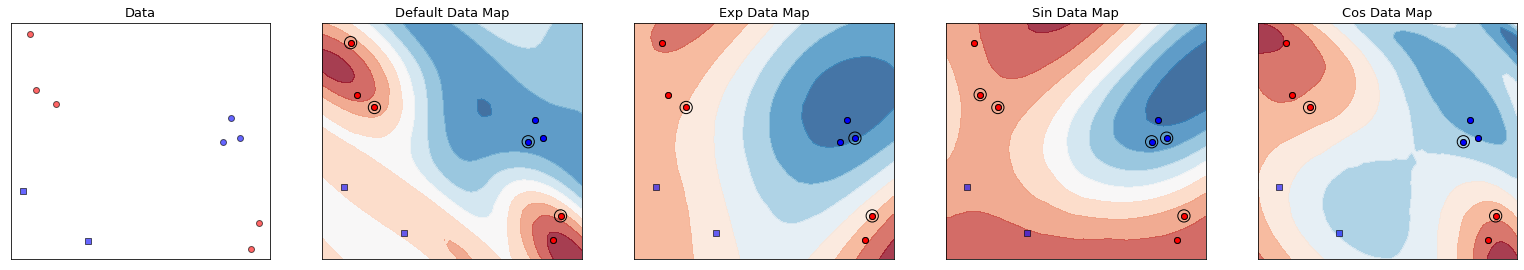

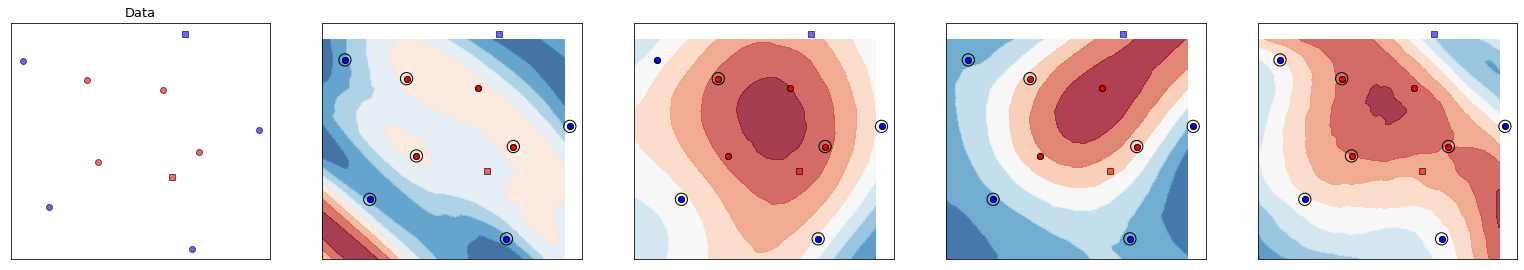

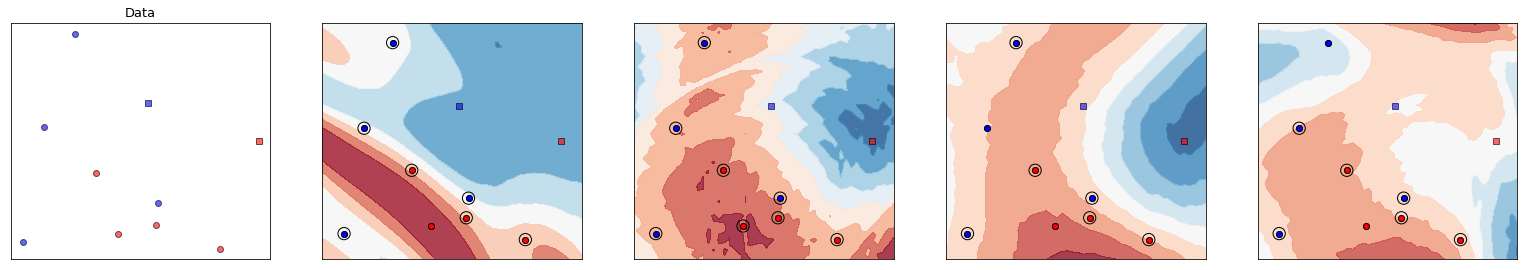

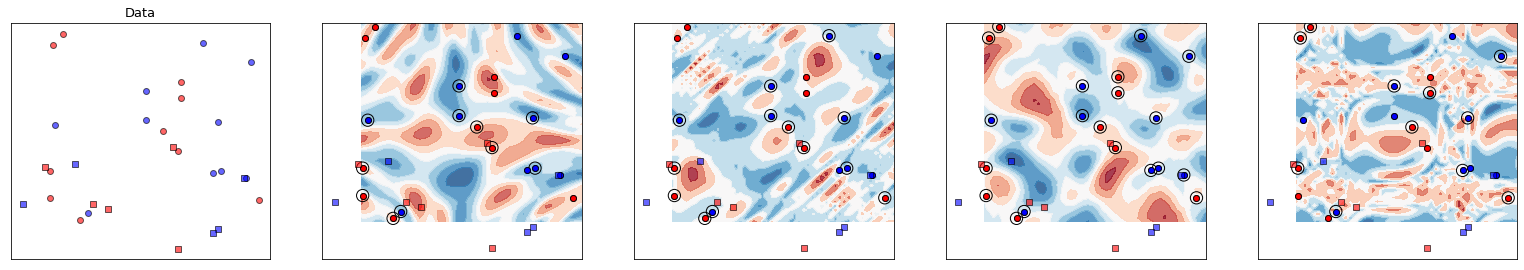

Time to compute: 535.7875156323115 min


In [175]:
compare_models(
    datasets, 
    classifiers, 
    ['Default Data Map',
     'Exp Data Map', 
     'Sin Data Map', 
     'Cos Data Map'],
)

[Return to Content](#Content)

### Model Performance

In [178]:
# Params

center = 1
params_xor = {
    'N': 80, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}


params_circles = {
    'N': 80, # number of samples
    'factor': 0.4, 
    'noise': 0.1,
    'seed': seed,
}

params_moons = {
    'N': 80, # number of samples
    'noise': 0.15,
    'seed': seed,
}

params_adhoc = {
    'train_size': 40,
    'test_size': 2,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

datasets = [
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    create_circles_data(
        params_circles['N'], 
        params_circles['factor'], 
        params_circles['noise'], 
        params_circles['seed']
    ),
    create_moons_data(
        params_moons['N'], 
        params_moons['noise'], 
        params_moons['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

In [184]:
model_performance_on_datamaps = compare_model_performance(
                                        datasets, 
                                        classifiers, 
                                        ['XOR Data', 'Cirles Data', 'Moons Data', 'Adhoc Data'],
                                        ['Default Data Map', 'Exp Data Map', 'Sin Data Map', 'Cos Data Map']
                                )


compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 9 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [01:02<00:00,  1.02batch/s]


Accuracy on training set: 100.0 %


100%|████████████████████████████████████████| 16/16 [00:14<00:00,  1.13batch/s]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 61 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:40<00:00,  6.26s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:38<00:00,  6.18s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:53<00:00,  6.46s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.67s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 9 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [01:00<00:00,  1.05batch/s]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [00:15<00:00,  1.07batch/s]


Cos Data Map computed!
compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:31<00:00,  7.05s/batch]


Accuracy on training set: 98.4375 %


100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.66s/batch]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 60 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:33<00:00,  6.15s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:35<00:00,  5.97s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:59<00:00,  6.56s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:54<00:00,  7.15s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:31<00:00,  7.06s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:49<00:00,  6.85s/batch]


Cos Data Map computed!
compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 62 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:31<00:00,  7.05s/batch]


Accuracy on training set: 85.9375 %


100%|████████████████████████████████████████| 16/16 [01:43<00:00,  6.48s/batch]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:59<00:00,  7.48s/batch]


Accuracy on training set: 89.0625 %


100%|████████████████████████████████████████| 16/16 [01:49<00:00,  6.86s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 63 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:39<00:00,  6.24s/batch]


Accuracy on training set: 87.5 %


100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.65s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:02<00:00,  6.61s/batch]


Accuracy on training set: 92.1875 %


100%|████████████████████████████████████████| 16/16 [01:45<00:00,  6.59s/batch]


Cos Data Map computed!
compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 13 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:45<00:00,  1.32s/batch]


Accuracy on training set: 100.0 %


100%|██████████████████████████████████████████| 4/4 [00:05<00:00,  1.28s/batch]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 79 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [11:13<00:00,  8.42s/batch]


Accuracy on training set: 86.25 %


100%|██████████████████████████████████████████| 4/4 [00:31<00:00,  7.81s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 80 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [11:53<00:00,  8.91s/batch]


Accuracy on training set: 81.25 %


100%|██████████████████████████████████████████| 4/4 [00:32<00:00,  8.05s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 80 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [10:43<00:00,  8.04s/batch]


Accuracy on training set: 70.0 %


100%|██████████████████████████████████████████| 4/4 [00:31<00:00,  7.84s/batch]


Cos Data Map computed!
Performance on Adhoc Data computed


Time to compute: 196.1936976313591 min


In [185]:
model_performance_on_datamaps


{'XOR Data': {'Default Data Map': 0.9375,
  'Exp Data Map': 1.0,
  'Sin Data Map': 1.0,
  'Cos Data Map': 1.0},
 'Cirles Data': {'Default Data Map': 1.0,
  'Exp Data Map': 1.0,
  'Sin Data Map': 1.0,
  'Cos Data Map': 1.0},
 'Moons Data': {'Default Data Map': 0.6875,
  'Exp Data Map': 0.625,
  'Sin Data Map': 0.8125,
  'Cos Data Map': 0.8125},
 'Adhoc Data': {'Default Data Map': 1.0,
  'Exp Data Map': 0.5,
  'Sin Data Map': 0.75,
  'Cos Data Map': 0.75}}

In [54]:
model_performance_on_datamaps = {'XOR Data': {
    'Default Data Map': 0.9375,
      'Exp Data Map': 1.0,
      'Sin Data Map': 1.0,
      'Cos Data Map': 1.0
    },
 'Cirles Data': {
     'Default Data Map': 1.0,
      'Exp Data Map': 1.0,
      'Sin Data Map': 1.0,
      'Cos Data Map': 1.0
     },
 'Moons Data': {
     'Default Data Map': 0.6875,
      'Exp Data Map': 0.625,
      'Sin Data Map': 0.8125,
      'Cos Data Map': 0.8125
     },
 'Adhoc Data': {
      'Default Data Map': 1.0,
      'Exp Data Map': 0.5,
      'Sin Data Map': 0.75,
      'Cos Data Map': 0.75
     }
}

In [57]:
pd.DataFrame.from_dict(model_performance_on_datamaps).transpose()

,Default Data Map,Exp Data Map,Sin Data Map,Cos Data Map
XOR Data,0.9375,1.000,1.0000,1.0000
Cirles Data,1.0000,1.000,1.0000,1.0000
Moons Data,0.6875,0.625,0.8125,0.8125
Adhoc Data,1.0000,0.500,0.7500,0.7500


In [63]:
dict_benchmark_qsvc_rbf = {'XOR Data': {
    'Default Data Map': 0.9375,
      'Exp Data Map': 1.0,
      'Sin Data Map': 1.0,
      'Cos Data Map': 1.0,
      'RBF SVC': 1.0,
    },
 'Cirles Data': {
     'Default Data Map': 1.0,
      'Exp Data Map': 1.0,
      'Sin Data Map': 1.0,
      'Cos Data Map': 1.0,
      'RBF SVC': 1.0,
     },
 'Moons Data': {
     'Default Data Map': 0.6875,
      'Exp Data Map': 0.625,
      'Sin Data Map': 0.8125,
      'Cos Data Map': 0.8125,
      'RBF SVC': 0.85,
     },
 'Adhoc Data': {
      'Default Data Map': 1.0,
      'Exp Data Map': 0.5,
      'Sin Data Map': 0.75,
      'Cos Data Map': 0.75,
     'RBF SVC': 0.55,
     },
}                         

In [64]:
pd.DataFrame.from_dict(dict_benchmark_qsvc_rbf).transpose()

,Default Data Map,Exp Data Map,Sin Data Map,Cos Data Map,RBF SVC
XOR Data,0.9375,1.000,1.0000,1.0000,1.00
Cirles Data,1.0000,1.000,1.0000,1.0000,1.00
Moons Data,0.6875,0.625,0.8125,0.8125,0.85
Adhoc Data,1.0000,0.500,0.7500,0.7500,0.55


[Return to Content](#Content)

### References

N. Mishra, M. Kapil, H. Rakesh, A. Anand, N. Mishra, A. Warke, S. Sarkar, S. Dutta,S. Gupta, A. P. Dash,et al., “Quantum machine learning: A review and current status”,Data Management, Analytics and Innovation, pp. 101–145, 2021.

Y. Liu, S. Arunachalam, and K. Temme, “A rigorous and robust quantum speed-up insupervised machine learning”,Nature Physics, vol. 17, no. 9, pp. 1013–1017, 2021.J. 

Biamonte, P. Wittek, N. Pancotti, P. Rebentrost, N. Wiebe, and S. Lloyd, “Quantummachine learning”,Nature, vol. 549, no. 7671, pp. 195–202, 2017.

C. M. Bishop,Pattern Recognition and Machine Learning. Springer, 2006.

S. Boyd, S. P. Boyd, and L. Vandenberghe,Convex optimization. Cambridge universitypress, 2004.

Y. Suzuki, H. Yano, Q. Gao, S. Uno, T. Tanaka, M. Akiyama, and N. Yamamoto,“Analysis and synthesis of feature map for kernel-based quantum classifier”,QuantumMachine Intelligence, vol. 2, no. 1, pp. 1–9, 2020.V. 

Havlıˇcek, A. D. Córcoles, K. Temme, A. W. Harrow, A. Kandala, J. M. Chow, andJ. M. Gambetta, “Supervised learning with quantum-enhanced feature spaces”,Nature, vol. 567, no. 7747, pp. 209–212, 2019.

A. Phan. (2021), 2021 qiskit global summer school on quantum machine learning - lab3: Introduction to quantum kernels and svms,  [Online]. Available:https://learn.qiskit.org/summer-school/2021/lab3-introduction-quantum-kernels-support-vector-machines(visited on 11/29/2021).